***
# E(S)DA, Clustering

<br><br>
### O. Kounadi, R. Zurita-Milla, and M. Khodadadzadeh
### Spatio-temporal analytics and modelling
<br> 
<br> 
*version: 3, September 2021*

***
# E(S)DA, Clustering & Regionalization
### Moran's I (Spatial Lag, Moran Scatterplot, Bivariate Moran Scatterplot)
### Descriptive statistics (measures, boxplot, Pearson correlation coefficient)
### Clustering (Kmeans)
******

<br><br>
### Data were downloaded from GeoDa Data and Lab: https://geodacenter.github.io/data-and-lab// 
### The full dataset and its attributes can be explored here: https://geodacenter.github.io/data-and-lab/nepal/ 
<br> 
<br> 
*Data have been processed and only a small number of variables are included in this practical.*

### Setting the environment

In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))
import esda

import pandas as pd
import geopandas as gpd
import libpysal as lps
import numpy as np
from sklearn import cluster

import matplotlib.pyplot as plt
import seaborn as sbn

%matplotlib inline

In [2]:
df = gpd.read_file(r"/data/shared/Big-Geodata-Processing-2021-1A/distributed_computing_machine_learning/Data//Nepal/nepal_dev.shp")

In [3]:
df.head()

,id,district,depecprov,povindex,pcinc,malkids,nosafh20,schlpkid,ad_illit,depr_class,geometry
0,0,Baglung,27.01,27.33,354,42.9,11.12,9.1924,34.46,1,"POLYGON ((83.10834 28.62020, 83.10560 28.60976..."
1,1,Mustang,31.51,31.16,1189,54.7,8.32,44.0252,38.65,1,"POLYGON ((83.99726 29.31675, 84.00000 29.31576..."
2,2,Myagdi,30.03,28.54,636,47.5,12.56,15.1096,34.84,1,"POLYGON ((83.50688 28.79306, 83.51024 28.78809..."
3,3,Parbat,21.84,24.62,627,26.2,17.47,16.4131,32.43,0,"POLYGON ((83.70261 28.39837, 83.70435 28.39452..."
4,4,Bhaktapur,22.58,19.43,854,26.9,18.25,11.1621,21.87,0,"POLYGON ((85.52173 27.71822, 85.52359 27.71375..."


### Mapping deprivation in economic provisioning in Nepal

<AxesSubplot:>

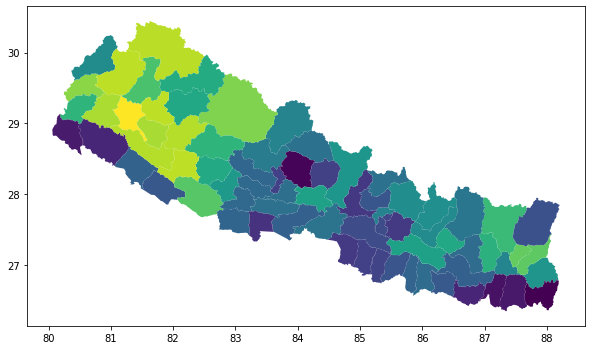

In [4]:
df = df
df['depecprov'].fillna((df['depecprov'].mean()), inplace = True)

df.plot(column = 'depecprov',
        figsize = (10,8))

<AxesSubplot:>

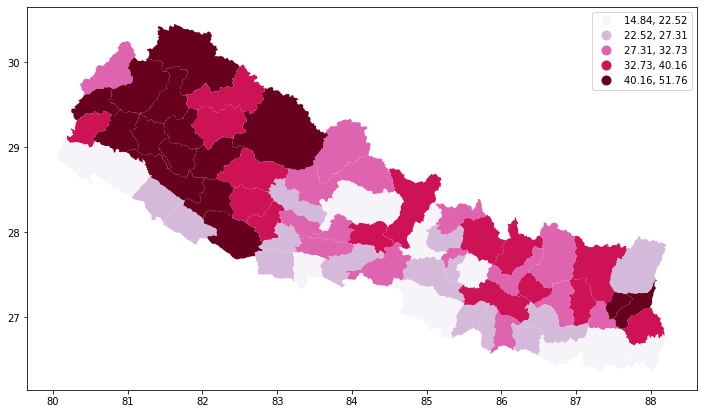

In [5]:
fig, ax = plt.subplots(figsize = (12,10), 
                       subplot_kw = {'aspect':'equal'})

df.plot(column = 'depecprov',
        scheme = 'quantiles',
        k = 5,
        cmap = 'PuRd', 
        legend = True, 
        ax = ax)

#ax.set_xlim(150000, 160000)
#ax.set_ylim(208000, 215000)

### The Spatial weight between neighborhoods indicates geographical similarity. The spatial lag measures this similarity.

In [6]:
wq = lps.weights.Queen.from_dataframe(df)
wq.transform = 'r'

In [7]:
economic_deprivation = df['depecprov']
ed = economic_deprivation

lag_depecprov = lps.weights.lag_spatial(wq, ed)

In [8]:
lag_depecprov

array([31.64666667, 34.40666667, 29.66      , 25.554     , 25.16      ,
       28.45166667, 24.12428571, 28.78285714, 24.51      , 28.3375    ,
       26.16333333, 28.48166667, 28.38      , 31.57333333, 29.33666667,
       31.57333333, 28.26333333, 26.76333333, 22.17333333, 25.12222222,
       24.66      , 26.3425    , 26.89166667, 30.926     , 31.95142857,
       27.92      , 33.254     , 23.4       , 34.5275    , 24.92      ,
       25.67      , 29.952     , 41.79666667, 32.72      , 30.288     ,
       22.50333333, 24.15333333, 34.75833333, 28.73111111, 41.645     ,
       32.165     , 46.715     , 28.83      , 46.134     , 42.81      ,
       46.69833333, 41.65714286, 35.478     , 38.84      , 34.825     ,
       48.745     , 44.44714286, 40.92857143, 37.07666667, 42.22      ,
       44.4275    , 43.64333333, 43.75      , 33.12833333, 32.156     ,
       38.13      , 39.095     , 37.77142857, 27.252     , 27.75833333,
       28.51      , 26.586     , 25.774     , 26.12142857, 29.78

### Mapping the spatial lag

In [9]:
import mapclassify as mc

economic_spatial_lag = mc.Quantiles(lag_depecprov, k = 5)

esl = economic_spatial_lag

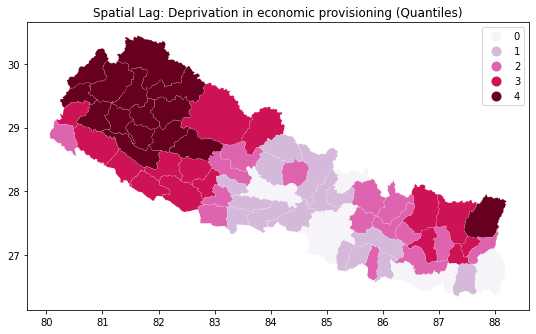

In [10]:
f, ax = plt.subplots(1, figsize = (9, 9))

df.assign(cl = esl.yb).plot(column = 'cl',
                               categorical = True,
                               k = 5,
                               cmap = 'PuRd',
                               linewidth = 0.1,
                               ax = ax,
                               edgecolor = 'white', 
                               legend = True)

plt.title("Spatial Lag: Deprivation in economic provisioning (Quantiles)")
plt.show()

### Using the median to dipict a binary classification (creating a spatial dichotomy)

In [11]:
# ed = economic deprivation
ed.median()

28.88

In [12]:
ed_upper = ed > ed.median()
sum(ed_upper)

37

In [13]:
ed_upper = ed > ed.median()
labels = ["0 Low", "1 High"]
ed_upper = [labels[i] for i in 1 * ed_upper]
df['ed_upper'] = ed_upper

<AxesSubplot:>

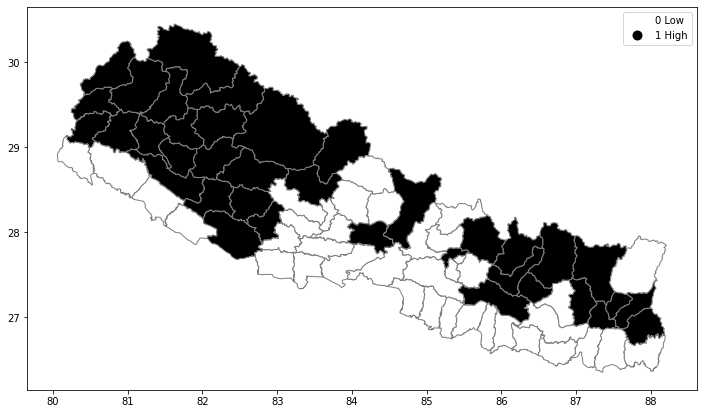

In [14]:
fig, ax = plt.subplots(figsize = (12,10), 
                       subplot_kw = {'aspect':'equal'})

df.plot(column = 'ed_upper',
        cmap = 'binary',
        edgecolor = 'grey',
        legend = True,
        ax = ax)

### Global spatial autocorrelation with Morans' I (mi = Moran I)

In [15]:
mi = esda.Moran(ed, wq, two_tailed = False)

round(mi.I, 3)

0.508

In [16]:
mi.EI

-0.013513513513513514

In [17]:
help (mi)

Help on Moran in module esda.moran object:

class Moran(builtins.object)
 |  Moran(y, w, transformation='r', permutations=999, two_tailed=True)
 |  
 |  Moran's I Global Autocorrelation Statistic
 |  
 |  Parameters
 |  ----------
 |  
 |  y               : array
 |                    variable measured across n spatial units
 |  w               : W
 |                    spatial weights instance
 |  transformation  : string
 |                    weights transformation,  default is row-standardized "r".
 |                    Other options include "B": binary,  "D":
 |                    doubly-standardized,  "U": untransformed
 |                    (general weights), "V": variance-stabilizing.
 |  permutations    : int
 |                    number of random permutations for calculation of
 |                    pseudo-p_values
 |  two_tailed      : boolean
 |                    If True (default) analytical p-values for Moran are two
 |                    tailed, otherwise if False, they a

Text(0.5, 0, "Moran's I")

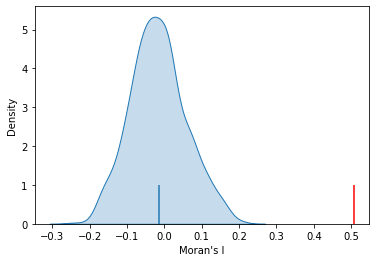

In [18]:
sbn.kdeplot(mi.sim, shade = True)
plt.vlines(mi.I, 0, 1, color = 'r')
plt.vlines(mi.EI, 0,1)
plt.xlabel("Moran's I")

In [19]:
mi.p_sim #checking p-values to confirm spatial autocorrelation

0.001

### Visualize the global autocorrelation

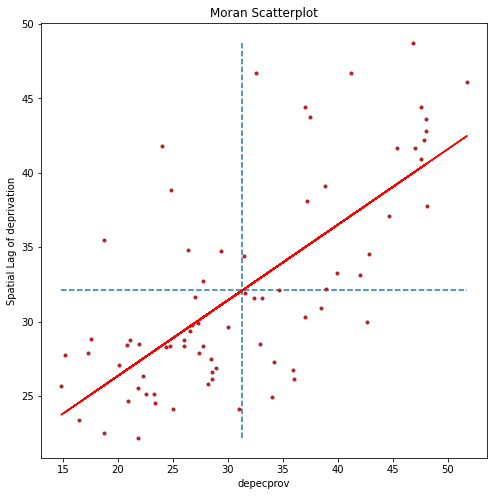

In [20]:
deprivation = df['depecprov']
b, a = np.polyfit(deprivation, lag_depecprov, 1)
f, ax = plt.subplots(1, figsize = (8, 8))
plt.plot(deprivation, lag_depecprov, '.', color = 'firebrick')

 # dashed vert at mean of depecprov
plt.vlines(deprivation.mean(), lag_depecprov.min(), lag_depecprov.max(), linestyle='--')

 # dashed horizontal at mean of laggged depecprov 
plt.hlines(lag_depecprov.mean(), deprivation.min(), deprivation.max(), linestyle='--')

 # red line of best fit using global I as slope
plt.plot(deprivation, a + b * deprivation, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of deprivation')
plt.xlabel('depecprov')
plt.show()

### Let's explore the spatial pattern of another variable...

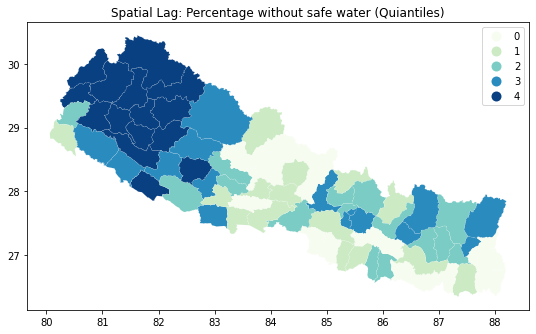

In [21]:
water = df['nosafh20']
lag_water = lps.weights.lag_spatial(wq, water)
water_spatial_lag = mc.Quantiles(lag_water, k = 5)
f, ax = plt.subplots(1, figsize = (9, 9))

df.assign(cl = water_spatial_lag.yb).plot(column = 'cl',
                                          categorical = True,
                                          k = 5,
                                          cmap = 'GnBu',
                                          linewidth = 0.1,
                                          ax = ax,
                                          edgecolor = 'white',
                                          legend = True)

plt.title("Spatial Lag: Percentage without safe water (Quiantiles)")

plt.show()

### Bivariate Moran I: deprivation and no safe water

In [22]:
mbi = esda.Moran_BV(deprivation, water, wq)
round(mbi.I, 3)

0.375

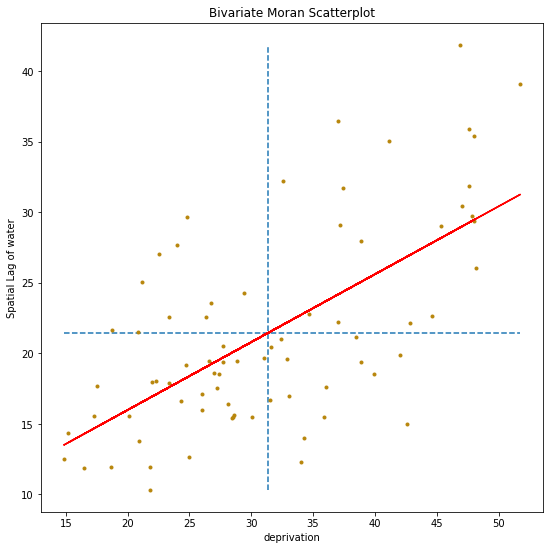

In [23]:
b, a = np.polyfit(deprivation, lag_water, 1)
f, ax = plt.subplots(1, figsize = (9, 9))
plt.plot(deprivation, lag_water, '.', color = 'darkgoldenrod')

# dashed vert at mean of depecprov
plt.vlines(deprivation.mean(), lag_water.min(), lag_water.max(), linestyle = '--')

# dashed horizontal at mean of laggged depecprov 
plt.hlines(lag_water.mean(), deprivation.min(), deprivation.max(), linestyle = '--')

# red line of best fit using global I as slope
plt.plot(deprivation, a + b * deprivation, 'r')
plt.title('Bivariate Moran Scatterplot')
plt.ylabel('Spatial Lag of water')
plt.xlabel('deprivation')

plt.show()

### Expolratory Data Analysis

In [24]:
df1 = pd.read_csv(r"/data/shared/Big-Geodata-Processing-2021-1A/distributed_computing_machine_learning/Data//Nepal/nepal_development.txt",
                  sep = ";",
                  index_col = False,
                  header = None,
                  names = ['district', 'deprevation', 'povetry', 'income', 'malnutrition', 'nosafewater', 'schools', 'illiteracy'])

df1

,district,deprevation,povetry,income,malnutrition,nosafewater,schools,illiteracy
0,Baglung,27.01,27.33,354,42.9,11.12,9.19,34.46
1,Mustang,31.51,31.16,1189,54.7,8.32,44.03,38.65
2,Myagdi,30.03,28.54,636,47.5,12.56,15.11,34.84
3,Parbat,21.84,24.62,627,26.2,17.47,16.41,32.43
4,Bhaktapur,22.58,19.43,854,26.9,18.25,11.16,21.87
...,...,...,...,...,...,...,...,...
70,Arghakhanchi,27.24,27.37,562,31.0,23.48,12.03,34.43
71,Gulmi,27.36,27.42,465,43.3,11.42,12.33,34.42
72,Nawalparasi,26.01,27.99,716,38.9,13.11,6.83,36.25
73,Palpa,28.42,25.23,609,35.9,20.93,11.29,29.18


In [25]:
df1.describe()

,deprevation,povetry,income,malnutrition,nosafewater,schools,illiteracy
count,75.000000,75.000000,75.000000,75.000000,75.00000,75.000000,75.000000
mean,31.318533,33.801467,668.200000,42.805333,19.83120,10.592533,42.523067
std,9.575262,7.658234,274.194545,10.969687,12.27485,9.392434,11.385943
min,14.840000,16.500000,301.000000,16.200000,2.14000,2.550000,15.960000
25%,24.170000,27.355000,493.500000,34.750000,10.64000,6.675000,34.445000
50%,28.880000,33.580000,623.000000,44.000000,19.26000,8.910000,41.830000
75%,37.950000,39.835000,754.500000,50.700000,29.61000,12.445000,51.815000
max,51.760000,49.260000,1959.000000,65.700000,48.12000,76.560000,66.110000


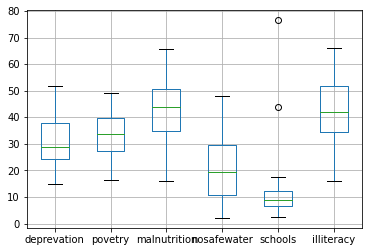

In [26]:
df1.boxplot(column = ['deprevation', 'povetry', 'malnutrition', 'nosafewater', 'schools', 'illiteracy'])

plt.show()

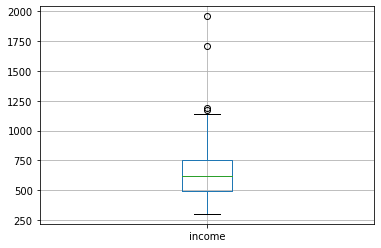

In [27]:
df1.boxplot(column = ['income'])

plt.show()

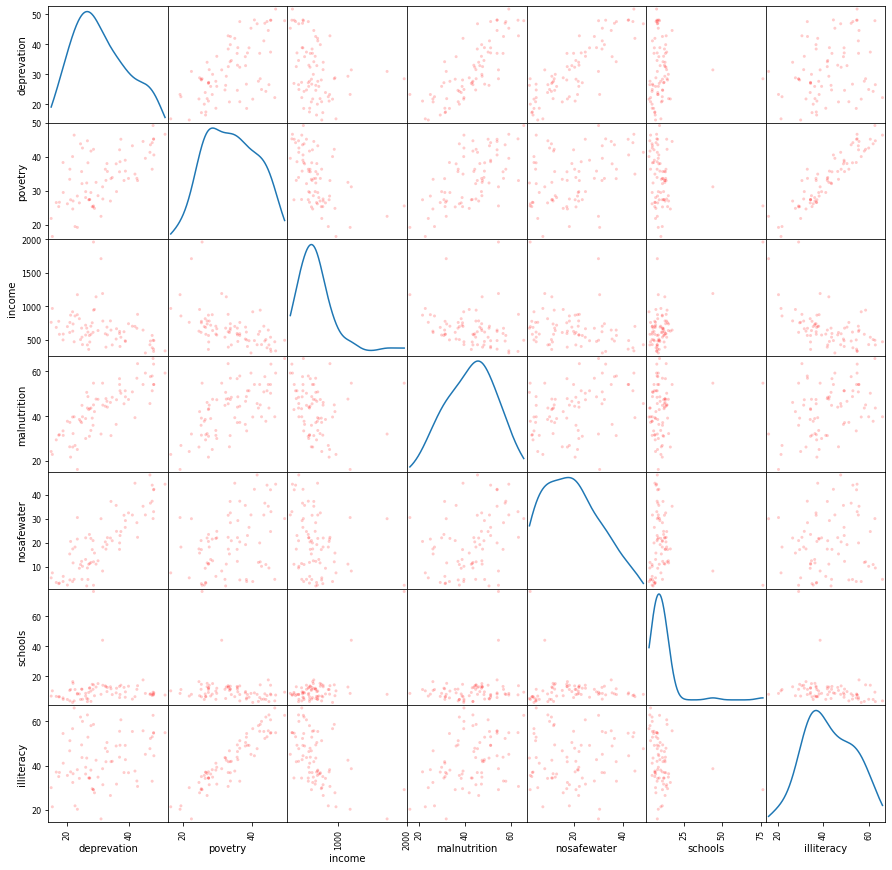

In [28]:
from pandas.plotting import scatter_matrix

scatter_matrix(df1,alpha = 0.2, 
               figsize = (15,15),
               diagonal = 'kde',
               c = 'r')

plt.show()

In [29]:
df1.corr()

,deprevation,povetry,income,malnutrition,nosafewater,schools,illiteracy
deprevation,1.000000,0.602468,-0.311448,0.800741,0.844595,0.036236,0.271536
povetry,0.602468,1.000000,-0.523750,0.632501,0.374649,-0.216883,0.923100
income,-0.311448,-0.523750,1.000000,-0.244366,-0.267537,0.590149,-0.522266
malnutrition,0.800741,0.632501,-0.244366,1.000000,0.355589,0.182216,0.395781
nosafewater,0.844595,0.374649,-0.267537,0.355589,1.000000,-0.106330,0.069884
schools,0.036236,-0.216883,0.590149,0.182216,-0.106330,1.000000,-0.259232
illiteracy,0.271536,0.923100,-0.522266,0.395781,0.069884,-0.259232,1.000000


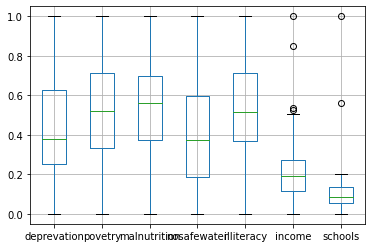

In [30]:
df1['deprevation'] = (df1['deprevation']-df1['deprevation'].min()) / (df1['deprevation'].max()-df1['deprevation'].min())
df1['povetry'] = (df1['povetry']-df1['povetry'].min()) / (df1['povetry'].max()-df1['povetry'].min())
df1['malnutrition'] = (df1['malnutrition']-df1['malnutrition'].min()) / (df1['malnutrition'].max()-df1['malnutrition'].min())
df1['nosafewater'] = (df1['nosafewater']-df1['nosafewater'].min()) / (df1['nosafewater'].max()-df1['nosafewater'].min())
df1['illiteracy'] = (df1['illiteracy']-df1['illiteracy'].min()) / (df1['illiteracy'].max()-df1['illiteracy'].min())
df1['income'] = (df1['income']-df1['income'].min()) / (df1['income'].max()-df1['income'].min())
df1['schools'] = (df1['schools']-df1['schools'].min()) / (df1['schools'].max()-df1['schools'].min())

df1.boxplot(column = ['deprevation', 'povetry', 'malnutrition', 'nosafewater', 'illiteracy', 'income', 'schools'])

plt.show()

In [31]:
df = df.merge(df1, on = 'district')

df.head()

,id,district,depecprov,povindex,pcinc,malkids,nosafh20,schlpkid,ad_illit,depr_class,geometry,ed_upper,deprevation,povetry,income,malnutrition,nosafewater,schools,illiteracy
0,0,Baglung,27.01,27.33,354,42.9,11.12,9.1924,34.46,1,"POLYGON ((83.10834 28.62020, 83.10560 28.60976...",0 Low,0.329632,0.330586,0.031966,0.539394,0.195302,0.089718,0.368893
1,1,Mustang,31.51,31.16,1189,54.7,8.32,44.0252,38.65,1,"POLYGON ((83.99726 29.31675, 84.00000 29.31576...",1 High,0.451517,0.447497,0.535585,0.777778,0.134406,0.560465,0.452443
2,2,Myagdi,30.03,28.54,636,47.5,12.56,15.1096,34.84,1,"POLYGON ((83.50688 28.79306, 83.51024 28.78809...",1 High,0.411430,0.367521,0.202051,0.632323,0.226620,0.169707,0.376471
3,3,Parbat,21.84,24.62,627,26.2,17.47,16.4131,32.43,0,"POLYGON ((83.70261 28.39837, 83.70435 28.39452...",0 Low,0.189599,0.247863,0.196622,0.202020,0.333406,0.187272,0.328415
4,4,Bhaktapur,22.58,19.43,854,26.9,18.25,11.1621,21.87,0,"POLYGON ((85.52173 27.71822, 85.52359 27.71375...",0 Low,0.209642,0.089438,0.333534,0.216162,0.350370,0.116336,0.117846


### Clustering with Kmeans

In [32]:
km3 = cluster.KMeans(n_clusters = 3)
km3_cls = km3.fit(df[['deprevation', 'povetry', 'income', 'malnutrition', 'nosafewater', 'schools', 'illiteracy']].values)

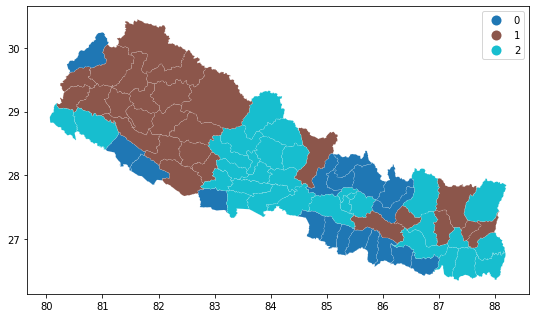

In [33]:
f, ax = plt.subplots(1, figsize = (9, 9))

df.assign(cl = km3_cls.labels_).plot(column = 'cl',
                                     categorical = True,
                                     legend = True,
                                     linewidth = 0.1,
                                     edgecolor = 'white',
                                     ax = ax)

plt.show()